## Code for 1D Simulation of Exclusive Active Matter in the Hydrodynamic Limit 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba.experimental import jitclass
from numba import njit
import dim_one_sim  

## Part 1: Finding Unstable Modes

### 1a: Theoretical stability boundary

In [2]:
def d_s(rho):
    alpha = np.pi/2 -1
    beta = alpha*(2*alpha-1)/(2*alpha+1)
    return (1-rho)*(1-alpha*rho + beta*rho**2)

def d_s_prime(rho):
    alpha = np.pi/2 -1
    beta = alpha*(2*alpha-1)/(2*alpha+1)
    return -(alpha+1)+2*(alpha+beta)*rho -3*beta*rho**2


In [40]:
L=20.0
D_0 = 1.0
D_E = 1.0
l = np.sqrt(D_E/D_0)
omega = 2*np.pi/L

def a(phi):
    return -D_E*d_s(phi)*(omega)**2

def b(phi, Pe):
    return -np.sqrt(D_0*D_E)*Pe/2*1.0j*(omega)*d_s(phi)

def W(phi, Pe):
    W = np.array([
        [-D_E*(omega)**2, -np.sqrt(D_0*D_E)*Pe/2*1.0j*(omega)*(1-phi), 0, 0, 0, 0, 0, 0, 0, 0],
        [2*b(phi, Pe) - np.sqrt(D_0*D_E)*Pe*1.0j*omega*phi*d_s_prime(phi), a(phi)-1*D_0, b(phi, Pe), 0, 0, 0, 0, 0, 0, 0],
        [0, b(phi, Pe), a(phi) - 4*D_0, b(phi, Pe), 0, 0, 0, 0, 0, 0],
        [0, 0, b(phi, Pe), a(phi) - 9*D_0, b(phi, Pe), 0, 0, 0, 0, 0],
        [0, 0, 0, b(phi, Pe), a(phi) - 16*D_0, b(phi, Pe), 0, 0, 0, 0],
        [0, 0, 0, 0, b(phi, Pe), a(phi) - 25*D_0, b(phi, Pe), 0, 0, 0],
        [0, 0, 0, 0, 0, b(phi, Pe), a(phi) - 36*D_0, b(phi, Pe), 0, 0],
        [0, 0, 0, 0, 0, 0, b(phi, Pe), a(phi) - 49*D_0, b(phi, Pe), 0],
        [0, 0, 0, 0, 0, 0, 0, b(phi, Pe), a(phi) - 64*D_0, b(phi, Pe)],
        [0, 0, 0, 0, 0, 0, 0, 0, b(phi, Pe), a(phi) - 81*D_0]
    ])
    return W

def stability(phi, Pe):
    W_ = W(phi, Pe)
    eigenvalues = np.linalg.eigvals(W_)
    largest_real_part = np.max(eigenvalues.real)
    if largest_real_part >= 0.0:
        return 0.0
    else:
        return 1.0
    
stability_picture = np.array([[stability(phi, Pe) for phi in np.linspace(0, 1, 200)] for Pe in np.linspace(0, 40, 200)])



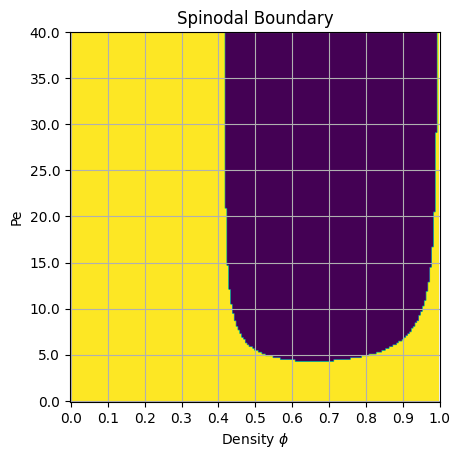

In [5]:
plt.imshow(stability_picture, origin='lower')
plt.xticks([])
plt.yticks(np.linspace(0, 200, 9), labels=np.linspace(0, 40, 9))
plt.xticks(np.linspace(0, 200, 11), labels=np.round(np.linspace(0, 1.0, 11), 3))
plt.xlabel(r'Density $\phi$')
plt.ylabel(r'Pe')
plt.title('Spinodal Boundary')
plt.grid()
plt.show()

In [46]:
def Pe_crit(phi):
    #found = False
    for Pe in np.linspace(0, 40, 500):
        stab = stability(phi, Pe)
        if stab == 0.0:# and found == False:
            return Pe

### 1b: Eigenfunctions & Simulated Instabilities

In [6]:
def maximal_instability_function(phi, Pe):
    W_ = W(phi, Pe)
    eigenvalues, eigenvectors = np.linalg.eig(W_)

    # Find the index of the eigenvalue with the largest real part
    index_max_real = np.argmax(eigenvalues.real)
    A_n = eigenvectors[:, index_max_real]

    def f_0(x, theta):
        eigenfunction = np.real(np.sum([A_n[k] * np.cos(k*theta) * np.exp(1.0j * 2*np.pi/20 * x) for k in range(10)]))
        return eigenfunction
    
    return f_0


growth of an instability:

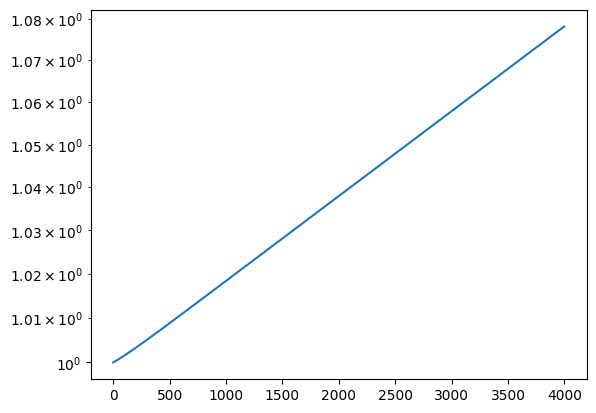

In [10]:
phi=0.65
Pe = 4.5

N_x = 200
N_theta = 30

test_f = dim_one_sim.f(N_x=N_x+2, N_theta=N_theta, v_0=Pe, L_x=20)

delta_f = maximal_instability_function(phi, Pe)
pertubation = np.array([[delta_f(x, theta) for theta in np.linspace(0, 2*np.pi, N_theta)] for x in np.linspace(0, 20, N_x)])
test_f.f[1:-1, :] = np.copy(phi/(2*np.pi)*np.ones((N_x, N_theta)) + 0.001*pertubation)

end_time = 40.0
test_f.evolve_to_time(t=end_time, recording_steps=1.0/200)

initial_dist = np.sqrt(np.sum(np.square(test_f.history_rho[0][1:-1] - phi)))
plt.plot([np.sqrt(np.sum(np.square(test_f.history_rho[i][1:-1]  - phi)))/initial_dist for i in range(len(test_f.history_rho))])
plt.yscale('log')

stability plot:

In [ ]:
N_x = 200
N_theta = 30
stabilities = []
x_s = []
y_s = []
for phi in np.linspace(0.4, 0.99, 30):
    for v_0 in np.concatenate((np.linspace(0.0, 10.0, 10), np.linspace(10.0, 30.0, 15))):
        #set up initial condiiton
        test_f = dim_one_sim.f(N_x=N_x+2, N_theta=N_theta, v_0=v_0, L_x=20)
        delta_f = maximal_instability_function(phi, v_0)
        pertubation = np.array([[delta_f(x, theta) for theta in np.linspace(0, 2*np.pi, N_theta)] for x in np.linspace(0, 20, N_x)])
        test_f.f[1:-1, :] = np.copy(phi/(2*np.pi)*np.ones((N_x, N_theta)) + 0.001*pertubation)
        x_s.append(phi)
        y_s.append(v_0)

        #run sim
        end_time = 4.0
        test_f.evolve_to_time(t=end_time, recording_steps=1.0/200)        

        #analyse stability
        initial_dist = np.sqrt(np.sum(np.square(test_f.history_rho[0][1:-1] - phi)))
        derivative = np.sign(np.sqrt(np.sum(np.square(test_f.history_rho[-1][1:-1]  - phi))) - np.sqrt(np.sum(np.square(test_f.history_rho[-50][1:-1]  - phi))))
        val = np.sign(np.sqrt(np.sum(np.square(test_f.history_rho[-1][1:-1]  - phi))) - initial_dist)

        if derivative*val >= 0.0:
            stability.append(val)
        else:
            stability.append(0.0)
    print(f'done v_0={v_0}, phi={phi}')

np.save('stability', stabilities)

binodal line:

In [19]:
N_x = 200
N_theta = 30
stability = []
x_s = []
y_s = []
v_0 = 12
phi = 0.65
denisities = []
v_0s = np.concatenate((np.linspace(0, 20, 20), np.linspace(20, 40, 10)))
for v_0 in v_0s:
    test_f = dim_one_sim.f(N_x=N_x+2, N_theta=N_theta, v_0=v_0, L_x=20)
    delta_f = maximal_instability_function(phi, v_0)
    pertubation = np.array([[delta_f(x, theta) for theta in np.linspace(0, 2*np.pi, N_theta)] for x in np.linspace(0, 20, N_x)])
    test_f.f[1:-1, :] = np.copy(phi/(2*np.pi)*np.ones((N_x, N_theta)) + 0.01*pertubation)
    if v_0 >= 5.0 and v_0 <= 15.0:
        test_f.evolve_to_time(100.0, recording_steps=1.0/100)
    else:
        test_f.evolve_to_time(50.0, recording_steps=1.0/100)
    init_vap, init_liq = np.min(test_f.history_rho[0]), np.max(test_f.history_rho[0])
    rho_ = test_f.history_rho[-1]
    vap = np.min(rho_)
    liq = np.max(rho_)
    if liq - vap > init_liq - init_vap:
        denisities.append([vap, liq])
    else:
        denisities.append([0.65, 0.65])

np.save('denisities', denisities)

/Users/noahgrodzinski/My Drive/PhD/Active Interfaces/Numerics_1D/no_wall_sims/dim_one_sim.py:226: RuntimeWarning: invalid value encountered in multiply
  self.f[1:-1, :] += df_dt_ * delta_t


plot:

In [68]:
theory_boundary = [Pe_crit(phi) for phi in np.linspace(0, 1, 500)]

(0.0, 30.0)

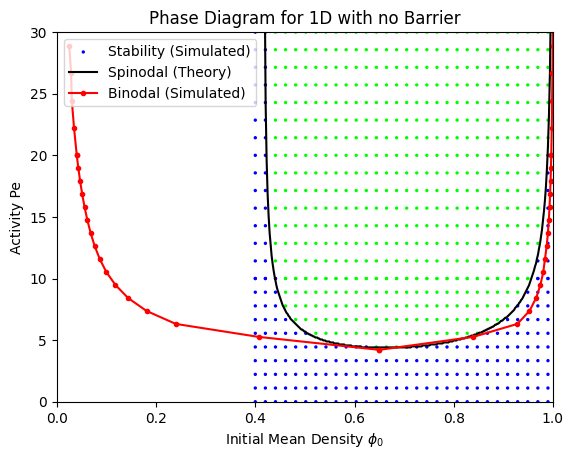

In [73]:
stabilities = np.load('stability.npy')
plt.scatter(x_s, y_s, c=stabilities, cmap='brg', label='Stability (Simulated)', s=2.0)


plt.plot(np.linspace(0, 1, 500), theory_boundary, color='black', label='Spinodal (Theory)')


liqs = [d[1] for d in denisities[4:]]
vaps = [d[0] for d in denisities[4:-5]]
plt.plot(liqs, v_0s[4:],  '.-r', label='Binodal (Simulated)')
plt.plot(vaps, v_0s[4:-5],  '.-r')
plt.xlim(left=0, right=1)
plt.ylim(top=30, bottom=0)
plt.legend(loc='upper left')
plt.xlabel(r'Initial Mean Density $\phi_0$')
plt.ylabel('Activity Pe')
plt.title('Phase Diagram for 1D with no Barrier')

plt.ylim(bottom=0, top=30)

## Part 2: Phases & Boundaries

In [161]:
test_f = dim_one_sim.f(N_x=200+2, N_theta=50, v_0 = 30, L_x=10)
phi = 0.6
delta_f = maximal_instability_function(phi, 15)
pertubation = np.array([[delta_f(x, theta) for theta in np.linspace(0, 2*np.pi, 50)] for x in np.linspace(0, 10, 200)])
test_f.f[1:-1, :] = np.copy(phi/(2*np.pi)*np.ones((200, 50)) + 0.03*pertubation)

test_f.evolve_to_time(t=100, recording_steps=1.0/200)

Text(0.5, 1.0, 'L=10, $D_E$=$D_0$=1, $v_0$=15, $\\phi_0$=0.6')

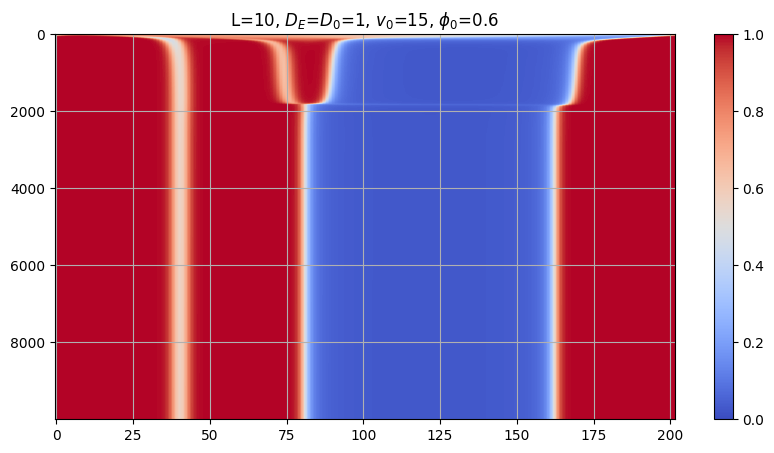

In [162]:
test_f.plot_history(2, 1)
plt.title(r'L=10, $D_E$=$D_0$=1, $v_0$=15, $\phi_0$=0.6')

0.9982347911576545
0.027951969923433826


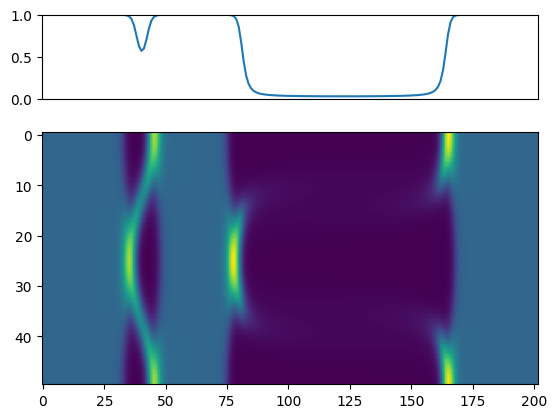

In [165]:
f = test_f.f
#if we want to normalize by local density
row_sums = f.sum(axis=1)
new_matrix = f / row_sums[:, np.newaxis]
fig, (ax1, ax2) = plt.subplots(2, height_ratios=(1,3))
ax2.imshow(f.T, aspect='auto', vmin=0.0)
rho_ = test_f.history_rho[-1]
ax1.plot(rho_)
ax1.set_ylim(bottom=0.0, top=1.0)
ax1.set_xlim(left=0.0, right=N_x-1)
ax1.set_xticks([])
print(np.max(rho_))
print(np.min(rho_))

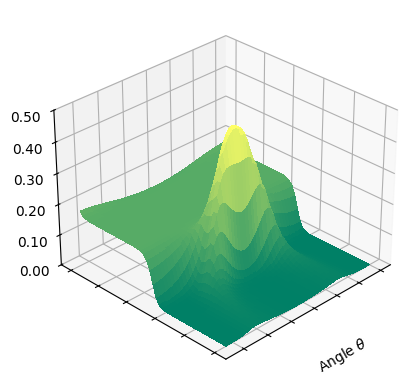

In [164]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
Y = np.linspace(0, 1, 50)
X = np.linspace(0, 2*np.pi, 50)
X, Y = np.meshgrid(X, Y)
Z = f[50:100, :]

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap='summer',
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 0.5)
#ax.zaxis.set_major_locator(LinearLocator(10))
ax.view_init(elev=30, azim=45)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlabel(r'Angle $\theta$')

ax.zaxis.set_major_formatter('{x:.02f}')

plt.show()